### アメリカワシントン州のキング郡（King County）内の不動産物件の価格データから、ランダムフォレストで住宅価格を予測

In [1]:
import numpy as np
import pandas as pd

# データ可視化
import matplotlib.pyplot as plt
import seaborn as sns

# 機械学習
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 決定木の可視化
from sklearn import tree
import graphviz

In [2]:
kcHouse_data = pd.read_csv('kc_house_data.csv')

In [3]:
# 基本統計量を表示
kcHouse_data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [4]:
# 「id（物件識別番号）」と「date（売却日時）」は不要なので削除
kcHouse_data = kcHouse_data.drop(['id', 'date'], axis=1)

In [5]:
# 「bedrooms（寝室の数）」でグルーピング
kcHouse_group_bedrooms = kcHouse_data.groupby('bedrooms', as_index=True).median()
kcHouse_group_bedrooms.head()

,price,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
bedrooms,,,,,,,,,,,,,,,,,,
0,288000.0,0.0,1470.0,5900.0,2.0,0.0,0.0,3.0,7.0,1470.0,0.0,1990.0,0.0,98065.0,47.52610,-122.168,1810.0,7200.0
1,299000.0,1.0,780.0,5750.0,1.0,0.0,0.0,3.0,6.0,760.0,0.0,1940.0,0.0,98116.0,47.56210,-122.315,1360.0,5650.0
2,374000.0,1.0,1140.0,5244.0,1.0,0.0,0.0,3.0,7.0,1010.0,0.0,1948.0,0.0,98116.0,47.60285,-122.316,1430.0,5400.0
3,413000.0,2.0,1680.0,7629.5,1.0,0.0,0.0,3.0,7.0,1440.0,0.0,1976.0,0.0,98059.0,47.56505,-122.231,1720.0,7688.5
4,549997.5,2.5,2410.0,8100.0,2.0,0.0,0.0,3.0,8.0,2080.0,0.0,1980.0,0.0,98056.0,47.57110,-122.192,2190.0,8000.0


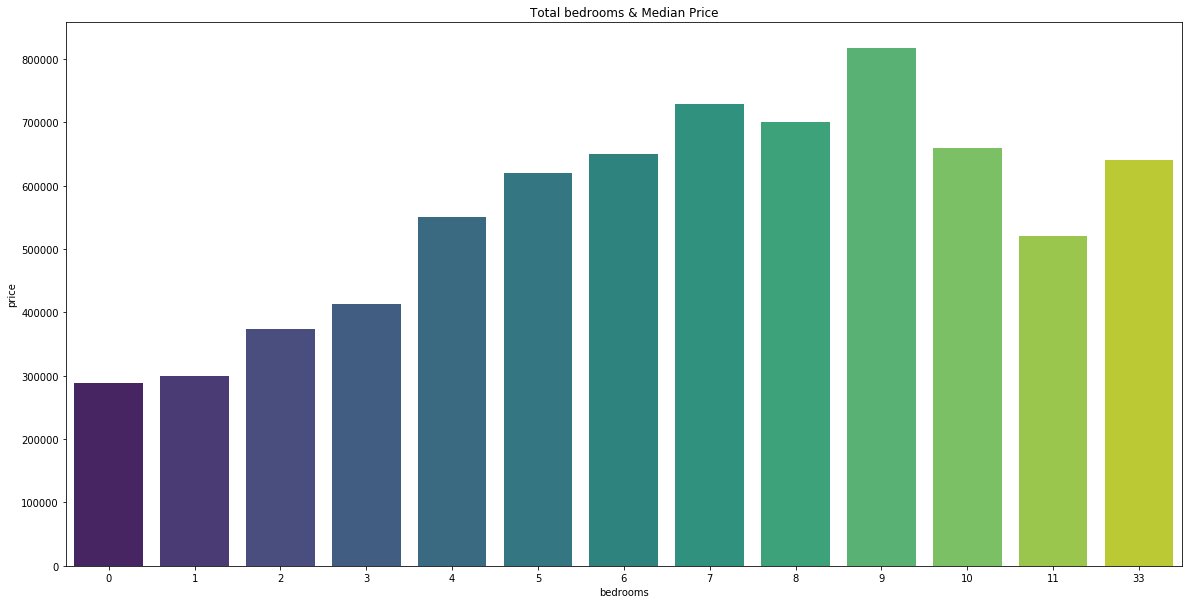

In [6]:
# 寝室の数と価格のグラフを表示
plt.figure(figsize=(20, 10))
plt.title('Total bedrooms & Median Price')
sns.barplot(x=kcHouse_group_bedrooms.index, y='price', data=kcHouse_group_bedrooms, palette='viridis')

In [7]:
kcHouse_data[kcHouse_data['bedrooms'] > 9]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8757,520000.0,11,3.00,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
13314,1148000.0,10,5.25,4590,10920,1.0,0,2,3,9,2500,2090,2008,0,98004,47.5861,-122.113,2730,10400
15161,650000.0,10,2.00,3610,11914,2.0,0,0,4,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914
15870,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700
19254,660000.0,10,3.00,2920,3745,2.0,0,0,4,7,1860,1060,1913,0,98105,47.6635,-122.320,1810,3745


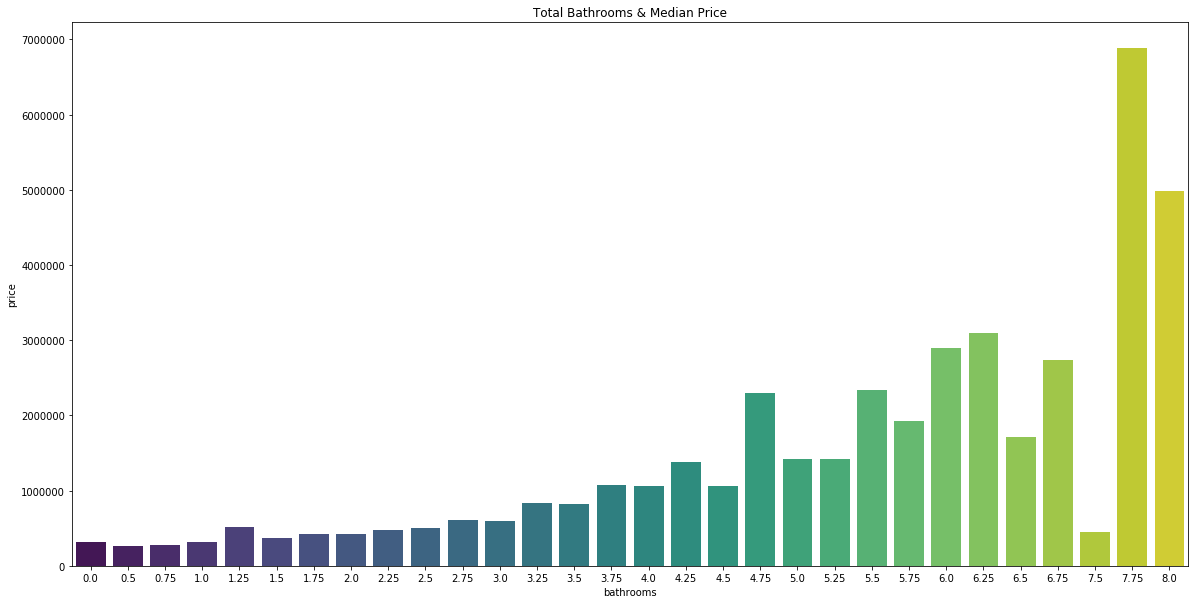

In [8]:
# トイレの数と価格のグラフを表示
kcHouse_group_bathrooms = kcHouse_data.groupby('bathrooms', as_index=True).median()

plt.figure(figsize=(20, 10))
plt.title('Total Bathrooms & Median Price')
sns.barplot(x=kcHouse_group_bathrooms.index, y='price', data=kcHouse_group_bathrooms, palette='viridis')

In [9]:
kcHouse_data[kcHouse_data['bathrooms'] > 6]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
4024,800000.0,7,6.75,7480,41664,2.0,0,2,3,11,5080,2400,1953,0,98166,47.4643,-122.368,2810,33190
7252,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
8092,4668000.0,5,6.75,9640,13068,1.0,1,4,3,12,4820,4820,1983,2009,98040,47.5570,-122.210,3270,10454
8546,450000.0,9,7.50,4050,6504,2.0,0,0,3,7,4050,0,1996,0,98144,47.5923,-122.301,1448,3866
9254,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
12777,2280000.0,7,8.00,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800
14556,2888000.0,5,6.25,8670,64033,2.0,0,4,3,13,6120,2550,1965,2003,98177,47.7295,-122.372,4140,81021
18302,3300000.0,5,6.25,8020,21738,2.0,0,0,3,11,8020,0,2001,0,98006,47.5675,-122.189,4160,18969
20578,1180000.0,6,6.50,6260,10955,2.0,0,0,3,11,4840,1420,2007,0,98075,47.5947,-122.039,2710,12550
21506,2238890.0,5,6.50,7270,130017,2.0,0,0,3,12,6420,850,2010,0,98027,47.5371,-121.982,1800,44890


C:\Users\owner\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\owner\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'SQFT of House & Median Price')

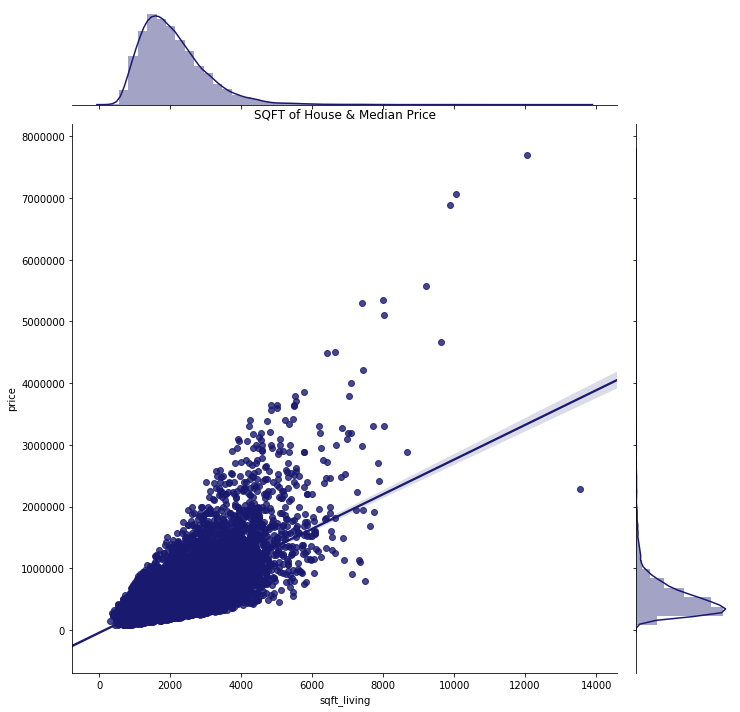

In [10]:
# 物件面積と価格の散布図
sns.jointplot(y='price', x='sqft_living', data=kcHouse_data, kind='reg', size=10, color='midnightblue')
plt.title('SQFT of House & Median Price')

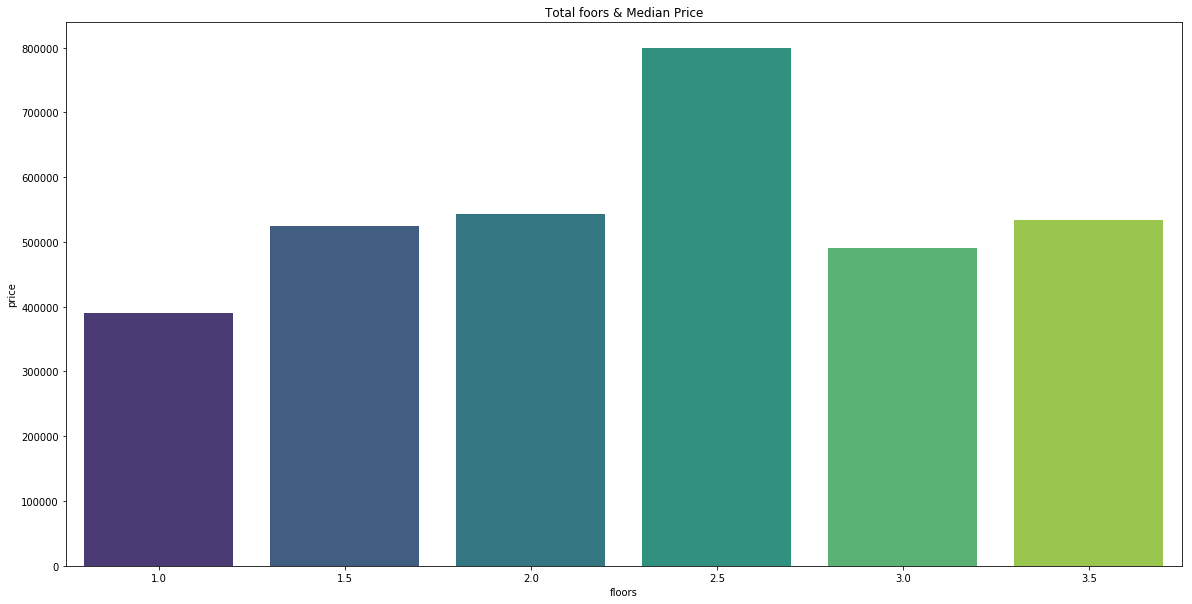

In [11]:
# 物件の回数と価格
kcHouse_group_floors = kcHouse_data.groupby('floors', as_index=True).median()

plt.figure(figsize=(20, 10))
plt.title('Total foors & Median Price')
sns.barplot(x=kcHouse_group_floors.index, y='price', data=kcHouse_group_floors, palette='viridis')

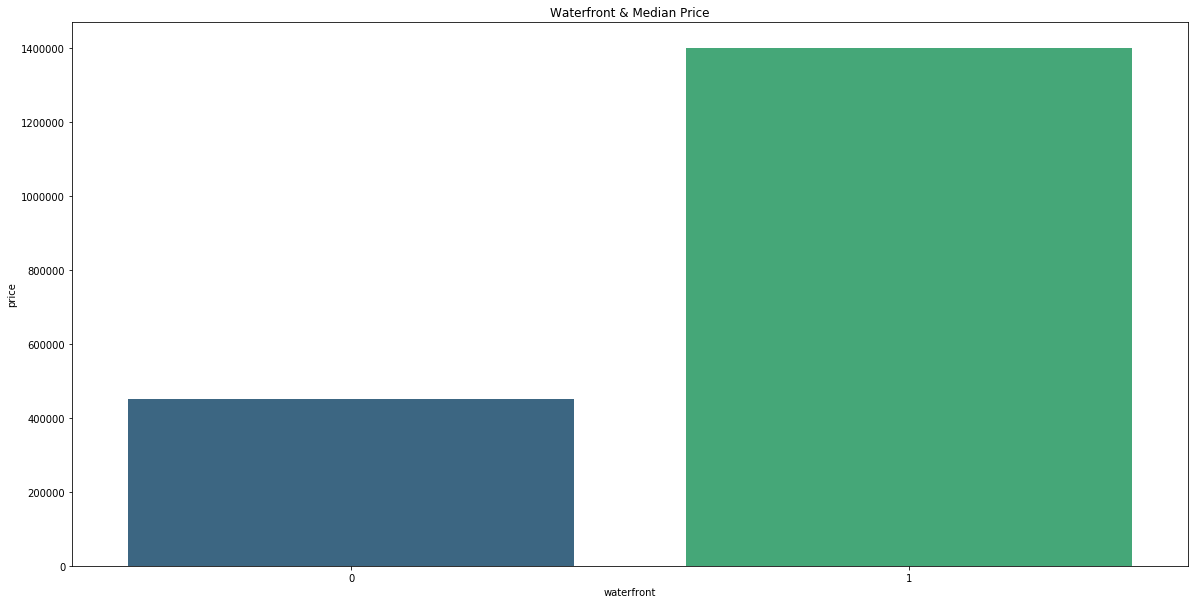

In [12]:
# 湖岸の景色の有無
kcHouse_group_waterfront = kcHouse_data.groupby('waterfront', as_index=True).median()

plt.figure(figsize=(20, 10))
plt.title('Waterfront & Median Price')
sns.barplot(x=kcHouse_group_waterfront.index, y='price', data=kcHouse_group_waterfront, palette='viridis')

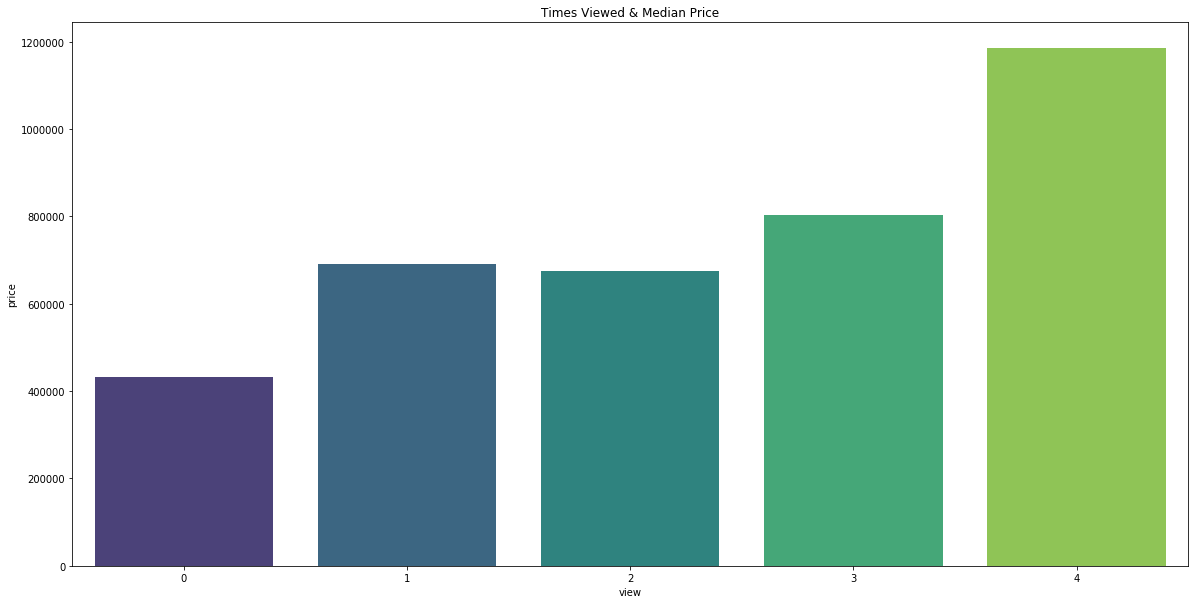

In [13]:
# 内見された数と価格
kcHouse_group_view = kcHouse_data.groupby('view', as_index=True).median()

plt.figure(figsize=(20, 10))
plt.title('Times Viewed & Median Price')
sns.barplot(x=kcHouse_group_view.index, y='price', data=kcHouse_group_view, palette='viridis')

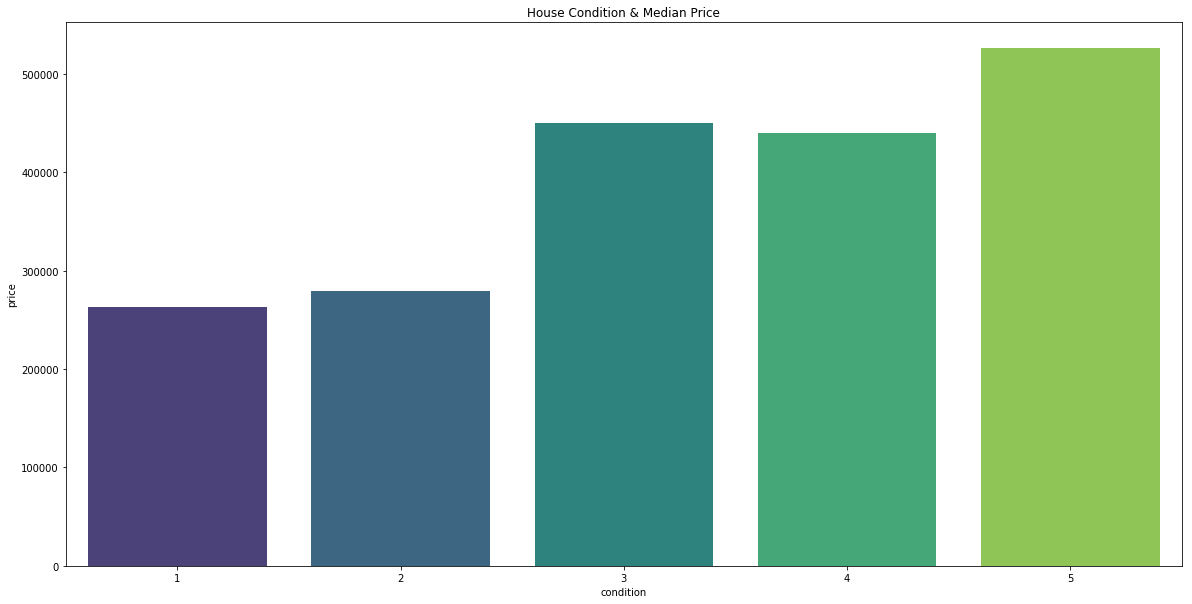

In [14]:
# 物件のコンディション
kcHouse_group_condition = kcHouse_data.groupby('condition', as_index=True).median()

plt.figure(figsize=(20, 10))
plt.title('House Condition & Median Price')
sns.barplot(x=kcHouse_group_condition.index, y='price', data=kcHouse_group_condition, palette='viridis')

In [15]:
kcHouse_group_condition.index

Int64Index([1, 2, 3, 4, 5], dtype='int64', name='condition')

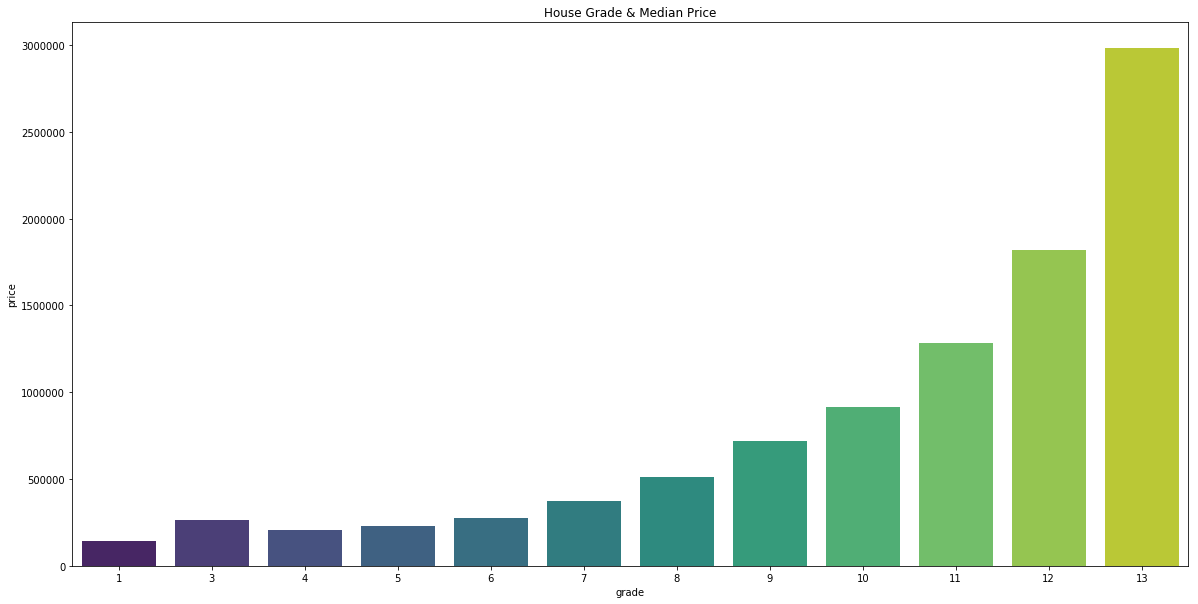

In [16]:
# 物件のグレードと価格
kcHouse_group_grade = kcHouse_data.groupby('grade', as_index=True).median()

plt.figure(figsize=(20, 10))
plt.title('House Grade & Median Price')
sns.barplot(x=kcHouse_group_grade.index, y='price', data=kcHouse_group_grade, palette='viridis')

C:\Users\owner\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'SQFT Above Ground & Median Price')

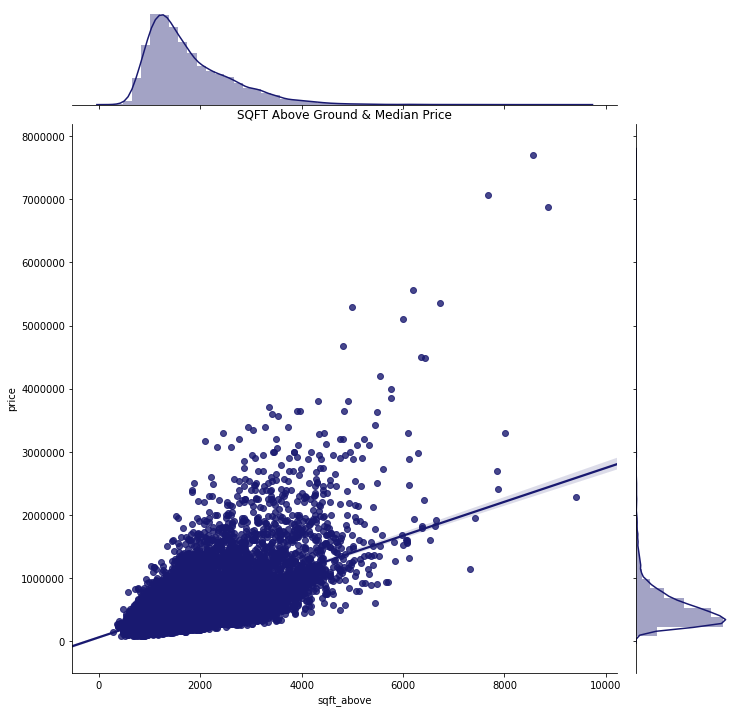

In [17]:
# 地上部広さと価格
sns.jointplot(x='sqft_above', y='price', data=kcHouse_data, kind='reg', size=10, color='midnightblue')
plt.title('SQFT Above Ground & Median Price')

C:\Users\owner\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


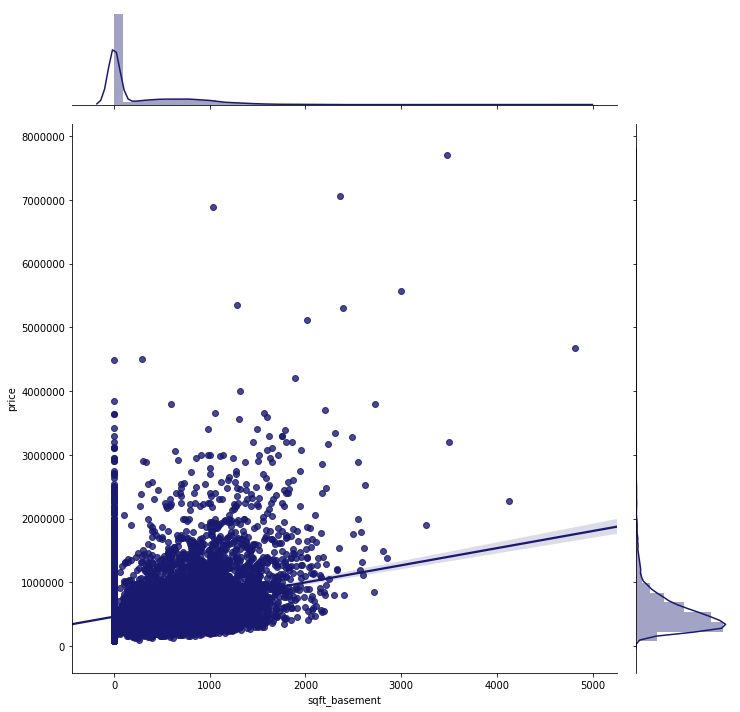

In [18]:
# 地下室の広さと価格
sns.jointplot(x='sqft_basement', y='price', data=kcHouse_data, kind='reg', size=10, color='midnightblue')

In [19]:
# 地下室がない物件の割合
float(kcHouse_data['sqft_basement'][kcHouse_data['sqft_basement'] == 0].count()) / len(kcHouse_data) * 100

60.73196687179012

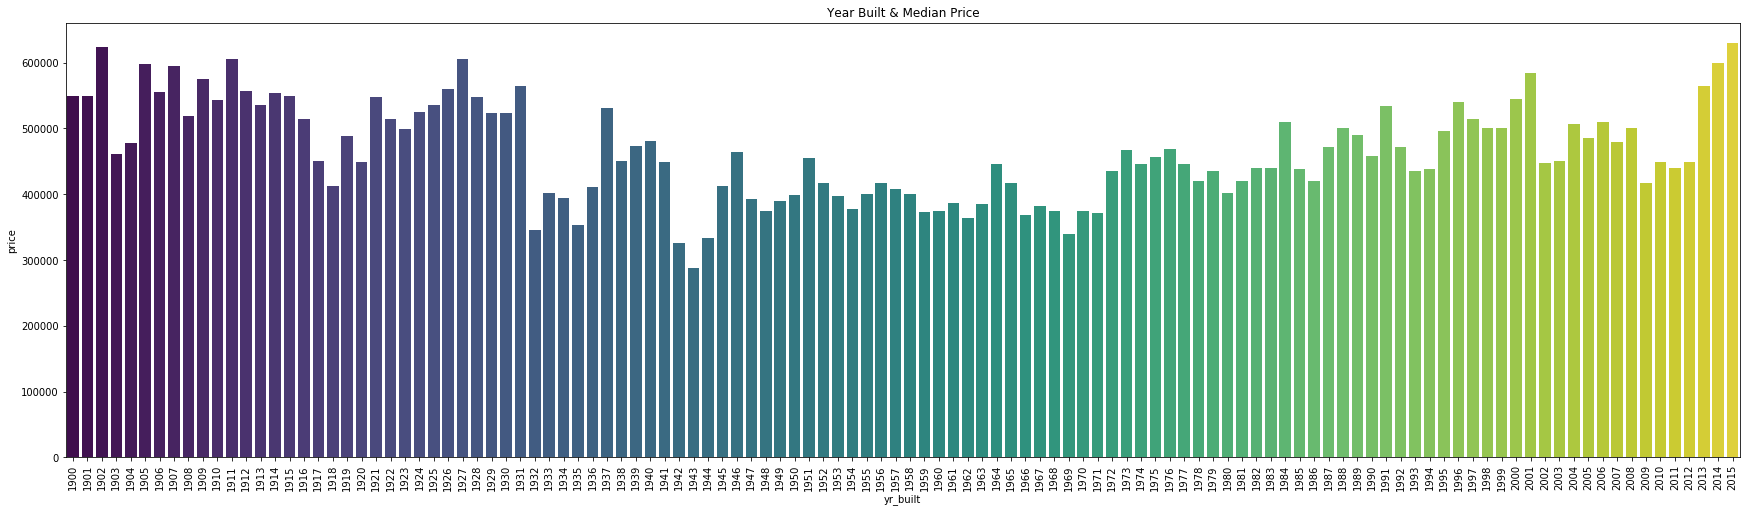

In [20]:
# 建造された年と価格
kcHouse_group_built = kcHouse_data.groupby('yr_built', as_index=True).median()

plt.figure(figsize=(30, 8))
plt.xticks(rotation=90)
plt.title('Year Built & Median Price')
sns.barplot(x=kcHouse_group_built.index, y='price', data=kcHouse_group_built, palette='viridis')

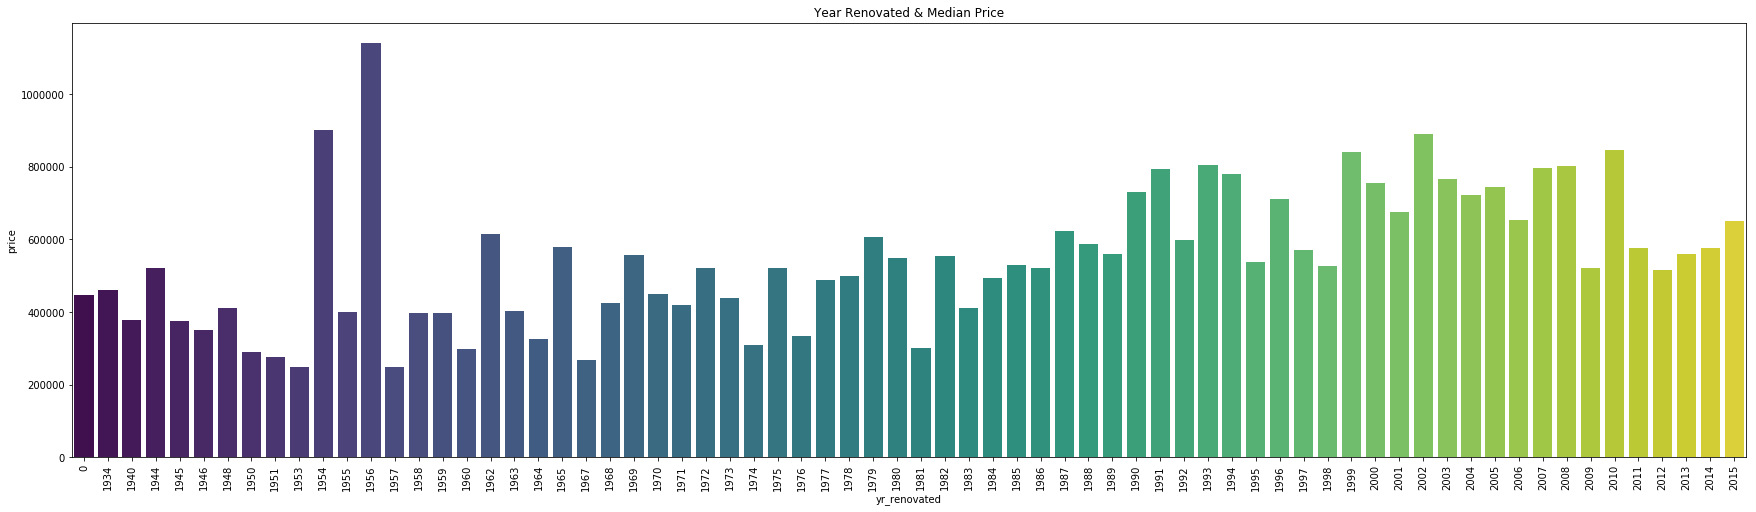

In [21]:
# リフォームされた年と価格
kcHouse_group_ren = kcHouse_data.groupby('yr_renovated', as_index=True).median()

plt.figure(figsize=(30, 8))
plt.xticks(rotation=90)
plt.title('Year Renovated & Median Price')
sns.barplot(x=kcHouse_group_ren.index, y='price', data=kcHouse_group_ren, palette='viridis')

In [22]:
# リフォームしていない物件の割合
float(kcHouse_data['yr_renovated'][kcHouse_data['yr_renovated'] == 0].count()) / len(kcHouse_data * 100)

0.9577106371165502

Text(0.5, 1.0, 'Renovated Flag & Median Price')

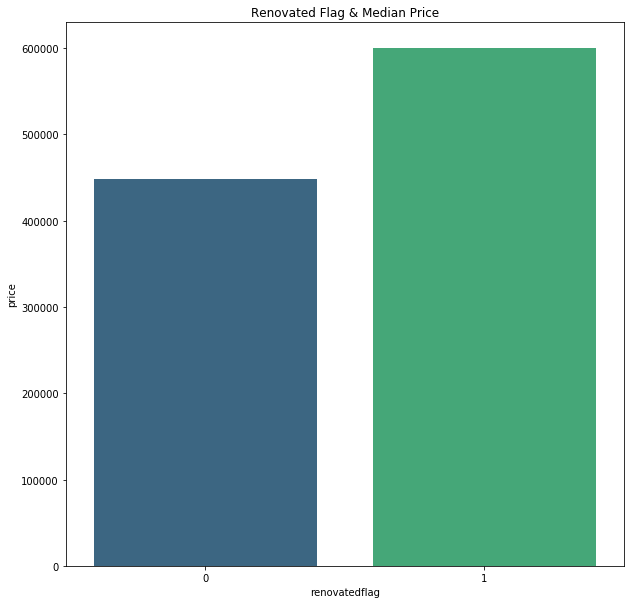

In [23]:
# リフォーム実施フラグを追加し価格と表示
kcHouse_data['renovatedflag'] = np.where(kcHouse_data['yr_renovated'] == 0, 0, 1)

kcHouse_group_ren_flag = kcHouse_data.groupby('renovatedflag', as_index=True).median()
plt.figure(figsize=(10, 10))
sns.barplot(x=kcHouse_group_ren_flag.index, y='price', data=kcHouse_group_ren_flag, palette='viridis')
plt.title('Renovated Flag & Median Price')


C:\Users\owner\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Sqft Change since 2015 & Price')

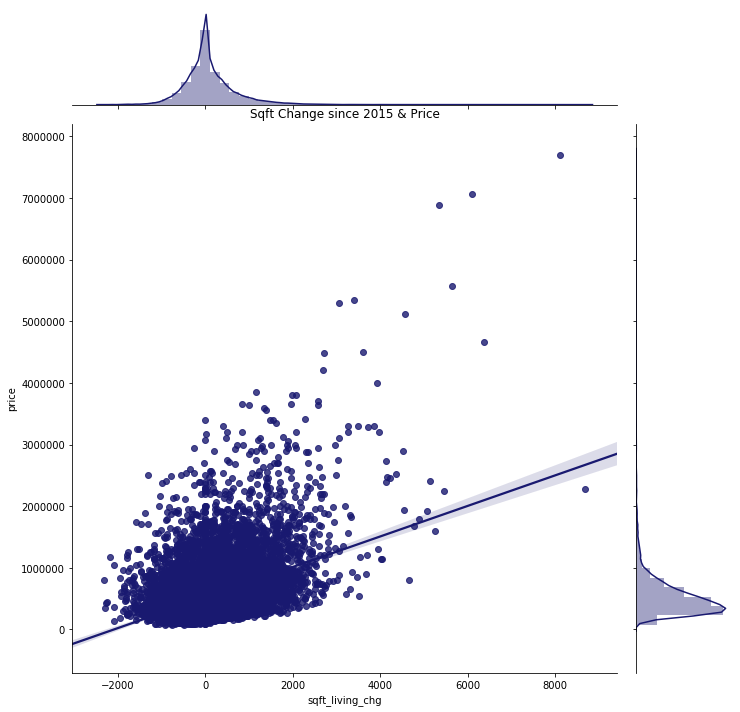

In [24]:
# 物件面積の変化量と価格
kcHouse_data['sqft_living_chg'] = kcHouse_data['sqft_living'] - kcHouse_data['sqft_living15']

sns.jointplot(x='sqft_living_chg', y='price', data=kcHouse_data, kind='reg', size=10, color='midnightblue')
plt.title('Sqft Change since 2015 & Price')

C:\Users\owner\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Sqft Lot Change & Price')

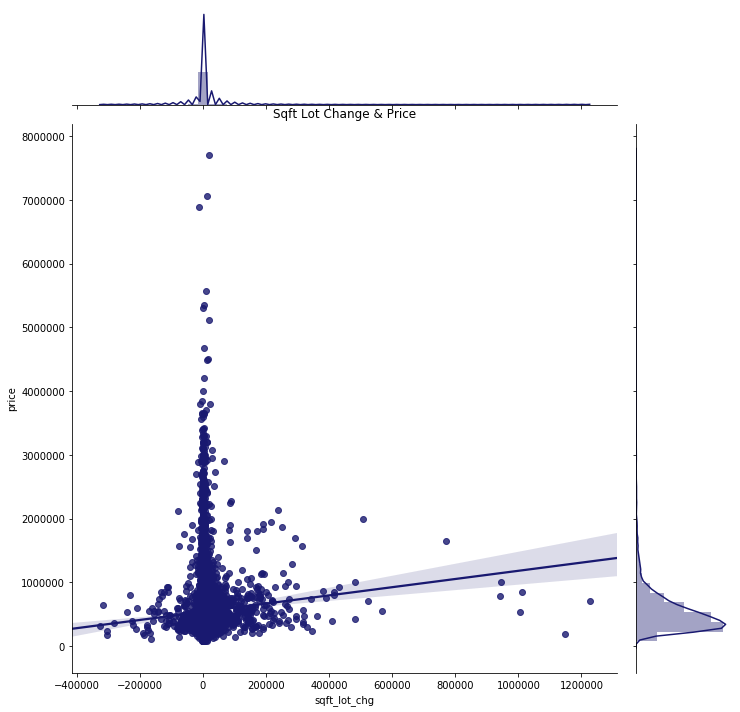

In [25]:
# 駐車場面積の変化量と価格
kcHouse_data['sqft_lot_chg'] = kcHouse_data['sqft_lot'] - kcHouse_data['sqft_lot15']

sns.jointplot(x='sqft_lot_chg', y='price', data=kcHouse_data, kind='reg', size=10, color='midnightblue')
plt.title('Sqft Lot Change & Price')

In [26]:
# 訓練データとテストデータに分割
train_set, test_set = train_test_split(kcHouse_data, test_size=0.2, random_state=42)

X_train = train_set.iloc[:, 1:]
y_train = train_set.iloc[:, :1]

X_test = test_set.iloc[:, 1:]
y_test = test_set.iloc[:, :1]

In [27]:
X_train.shape, X_test.shape

((17290, 21), (4323, 21))

In [28]:
# ランダムフォレストの設定
RFclf = RandomForestRegressor(n_estimators=100, criterion='mse')

# モデル訓練
RFclf = RFclf.fit(X_train, y_train)

C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [29]:
# 各特徴量を重要度順にソートして表示
features = X_train.columns
importances = RFclf.feature_importances_

print('Features sorted by most importances:')
print(sorted(zip(map(lambda x: round(x, 3), RFclf.feature_importances_), features),
           reverse=True))

Features sorted by most importances:
[(0.322, 'grade'), (0.258, 'sqft_living'), (0.151, 'lat'), (0.061, 'long'), (0.034, 'yr_built'), (0.03, 'waterfront'), (0.029, 'sqft_living15'), (0.019, 'sqft_above'), (0.014, 'zipcode'), (0.014, 'sqft_living_chg'), (0.012, 'sqft_lot15'), (0.012, 'sqft_lot'), (0.01, 'view'), (0.009, 'sqft_lot_chg'), (0.009, 'bathrooms'), (0.006, 'sqft_basement'), (0.003, 'condition'), (0.003, 'bedrooms'), (0.002, 'yr_renovated'), (0.002, 'floors'), (0.0, 'renovatedflag')]


In [30]:
# 全データでも確認
RFclf2 = RandomForestRegressor(n_estimators=100, criterion='mse')

RFclf2 = RFclf2.fit(kcHouse_data.iloc[:, 1:], kcHouse_data.iloc[:, :1])

C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [31]:
feature_col = kcHouse_data.iloc[:, 1:].columns
importances2 = RFclf2.feature_importances_

In [32]:
print("重要度が高い特徴量順：")
print(sorted(zip(map(lambda x: round(x, 4), RFclf2.feature_importances_), feature_col),
           reverse=True))

重要度が高い特徴量順：
[(0.3139, 'grade'), (0.2695, 'sqft_living'), (0.1627, 'lat'), (0.0678, 'long'), (0.0303, 'waterfront'), (0.0288, 'sqft_living15'), (0.0227, 'yr_built'), (0.0203, 'sqft_above'), (0.0133, 'zipcode'), (0.0119, 'sqft_lot15'), (0.0118, 'sqft_lot'), (0.0107, 'view'), (0.0084, 'sqft_lot_chg'), (0.0078, 'sqft_living_chg'), (0.0062, 'bathrooms'), (0.0047, 'sqft_basement'), (0.0027, 'condition'), (0.0026, 'bedrooms'), (0.0018, 'floors'), (0.0014, 'yr_renovated'), (0.0005, 'renovatedflag')]


In [33]:
features_sort = sorted(zip(map(lambda x: round(x, 4), RFclf2.feature_importances_), feature_col), reverse=True)

In [99]:
rate, features_important = list(zip(*features_sort))

In [100]:
features_important

('grade',
 'sqft_living',
 'lat',
 'long',
 'waterfront',
 'sqft_living15',
 'yr_built',
 'sqft_above',
 'zipcode',
 'sqft_lot15',
 'sqft_lot',
 'view',
 'sqft_lot_chg',
 'sqft_living_chg',
 'bathrooms',
 'sqft_basement',
 'condition',
 'bedrooms',
 'floors',
 'yr_renovated',
 'renovatedflag')

In [101]:
features_important = features_important[:7]

In [102]:
features_important

('grade',
 'sqft_living',
 'lat',
 'long',
 'waterfront',
 'sqft_living15',
 'yr_built')

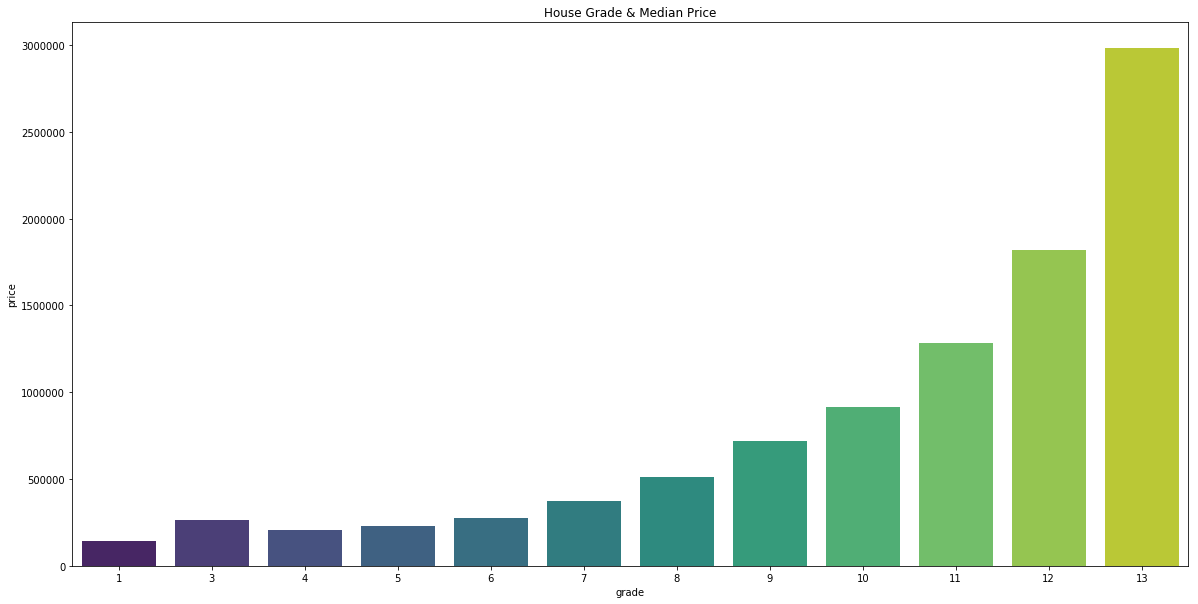

In [38]:
# 物件のグレードと価格
kcHouse_group_grade = kcHouse_data.groupby('grade', as_index=True).median()

plt.figure(figsize=(20, 10))
plt.title('House Grade & Median Price')
sns.barplot(x=kcHouse_group_grade.index, y='price', data=kcHouse_group_grade, palette='viridis')

C:\Users\owner\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\owner\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'SQFT of House & Median Price')

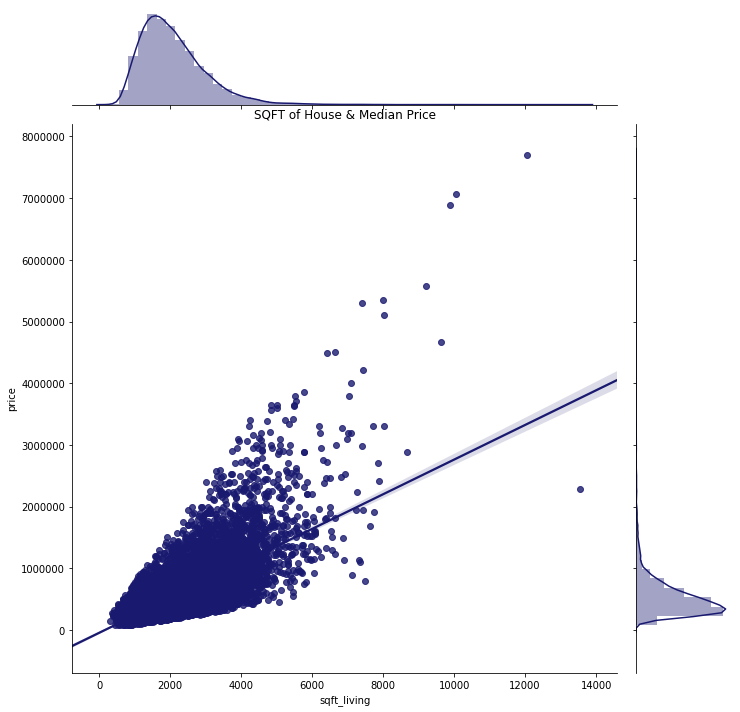

In [39]:
# 物件面積と価格の散布図
sns.jointplot(y='price', x='sqft_living', data=kcHouse_data, kind='reg', size=10, color='midnightblue')
plt.title('SQFT of House & Median Price')

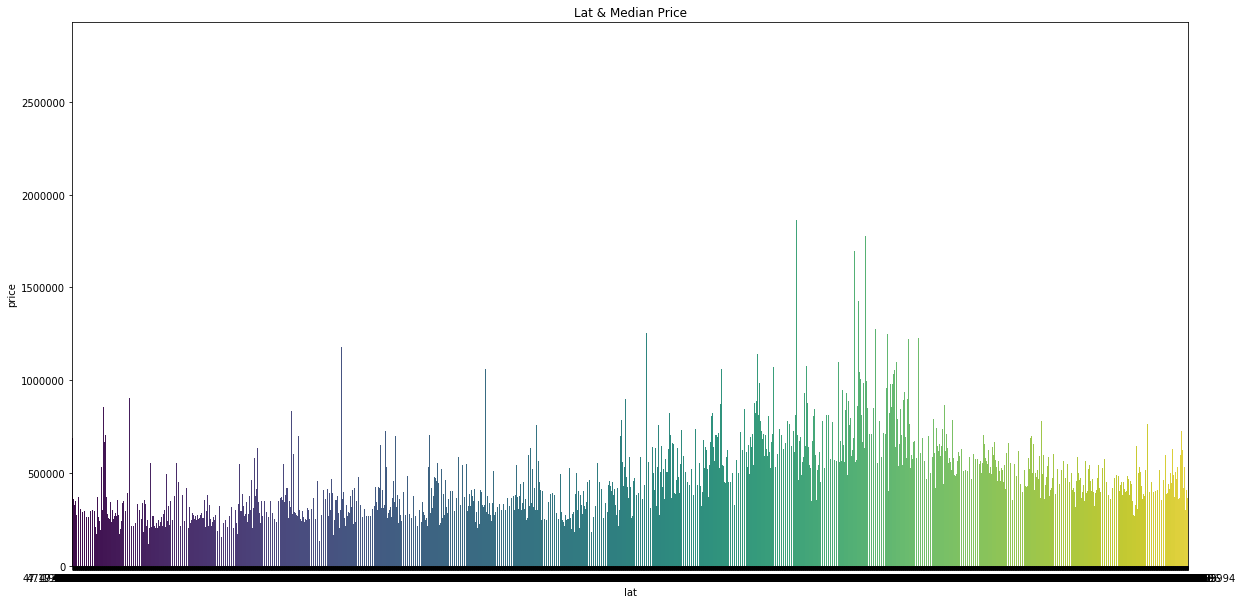

In [40]:
# 緯度と価格
kcHouse_group_lat = kcHouse_data.groupby('lat', as_index=True).median()

plt.figure(figsize=(20, 10))
plt.title('Lat & Median Price')
sns.barplot(x=kcHouse_group_lat.index, y='price', data=kcHouse_group_lat, palette='viridis')

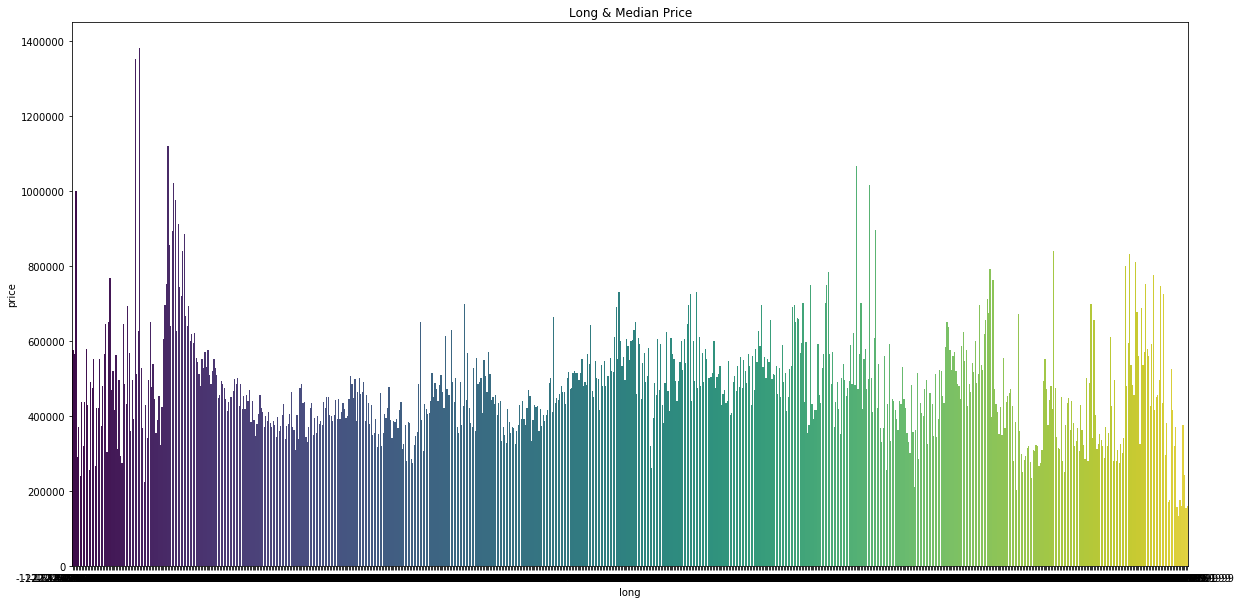

In [41]:
# 緯度と価格
kcHouse_group_long = kcHouse_data.groupby('long', as_index=True).median()

plt.figure(figsize=(20, 10))
plt.title('Long & Median Price')
sns.barplot(x=kcHouse_group_long.index, y='price', data=kcHouse_group_long, palette='viridis')

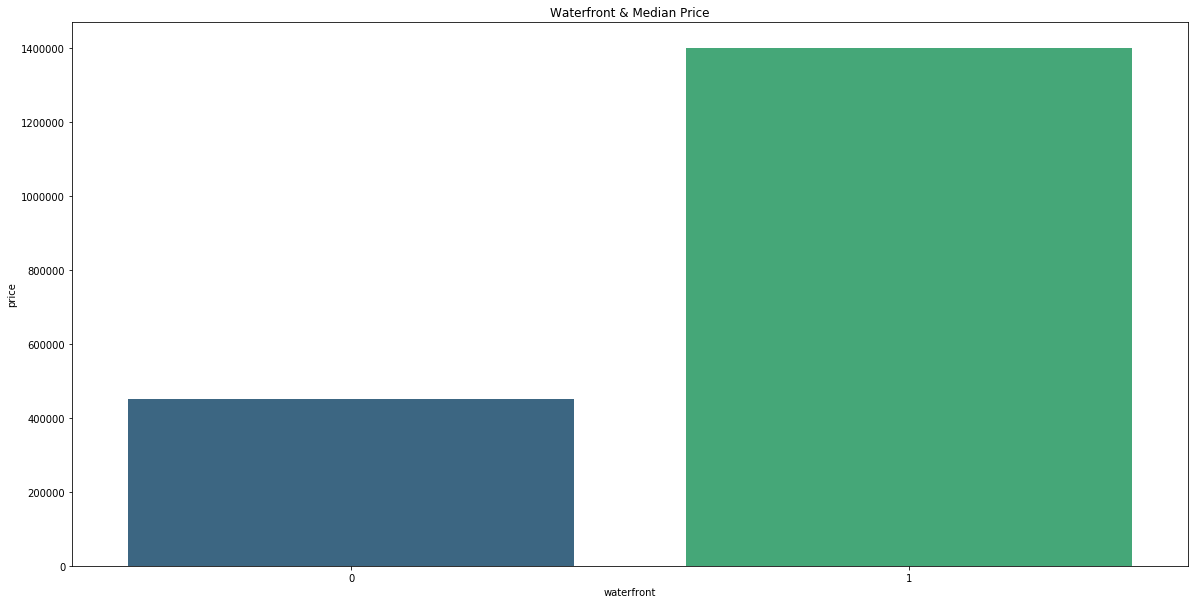

In [42]:
# 湖岸の景色の有無
kcHouse_group_waterfront = kcHouse_data.groupby('waterfront', as_index=True).median()

plt.figure(figsize=(20, 10))
plt.title('Waterfront & Median Price')
sns.barplot(x=kcHouse_group_waterfront.index, y='price', data=kcHouse_group_waterfront, palette='viridis')

In [43]:
# 決定木モデル
clf = DecisionTreeRegressor(max_depth=3)

# 訓練データで学習
clf = clf.fit(X_train, y_train)

# 訓練データで予測
y_pred = clf.predict(X_train)

In [44]:
# 訓練データでの二乗和誤差　RMSE
np.sqrt(mean_squared_error(y_train, y_pred))

225308.37182878164

In [45]:
# テストデータで予測
y_pred_test = clf.predict(X_test)

# テストデータでの二乗和誤差　RMSE
np.sqrt(mean_squared_error(y_test, y_pred_test))

257117.9540962996

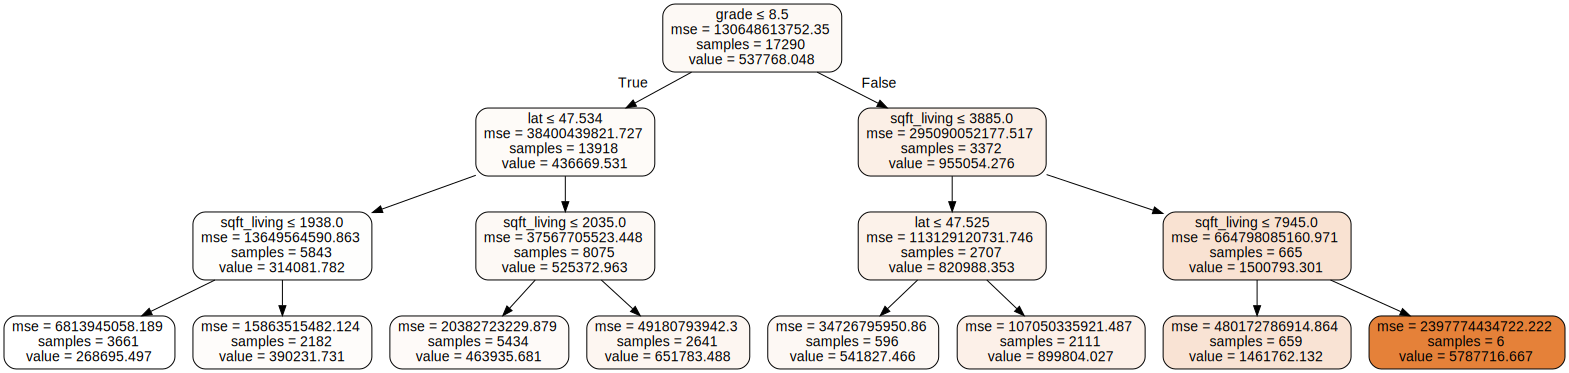

In [47]:
# 決定木の可視化
dot_data = tree.export_graphviz(clf, out_file=None,
                               feature_names=X_train.columns,
                               class_names=X_train,
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [103]:
# ランダムフォレスト
RFclf = RandomForestRegressor(n_estimators=100)

# 訓練データで学習
RFclf = RFclf.fit(X_train, y_train)

# 訓練データでの予測
RF_y_pred = RFclf.predict(X_train)

C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [104]:
# ランダムフォレスト　訓練データでの　RMSE
np.sqrt(mean_squared_error(y_train, RF_y_pred))

49108.096856975164

In [105]:
# テストデータでの予測
RF_y_pred_test = RFclf.predict(X_test)

# ランダムフォレスト　テストデータでの　RMSE
np.sqrt(mean_squared_error(y_test, RF_y_pred_test))

148099.32605539172

In [106]:
# 正解値と予測値の比較
# RF_y_pred_test_reshape = RF_y_pred_test.reshape((-1, 1))
# DFRFtest = pd.DataFrame({'Actual': y_test, 'Prediction': RF_y_pred_test})
RF_y_pred_test_df = pd.DataFrame(RF_y_pred_test)
y_test_idx_reset = y_test.reset_index(drop=True)
DFRFtest = pd.concat([y_test_idx_reset, RF_y_pred_test_df], axis=1)
DFRFtest.columns = ['Actual', 'Prediction']

In [107]:
y_test.shape, RF_y_pred_test_reshape.shape

((4323, 1), (4323, 1))

In [108]:
type(y_test), type(RF_y_pred_test)

(pandas.core.frame.DataFrame, numpy.ndarray)

In [109]:
DFRFtest.head()

,Actual,Prediction
0,365000.0,3.781445e+05
1,865000.0,8.588646e+05
2,1038000.0,1.123303e+06
3,1490000.0,1.990092e+06
4,711000.0,7.145139e+05
